In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
from time import time

import joblib

# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


from bayes_opt import BayesianOptimization

# Libraries for Deep Learning Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# needed for `HistGradientBoostingClassifier`
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# from `keras.optimizers` import SGD

In [3]:
# To fetch financial data
import yfinance as yf

# Set the ticker as 'BTC-USD'
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(period="5y")

In [4]:
# BTC_Ticker = yf.Ticker("BTC-USD")
# BTC_Data = BTC_Ticker.history(period="max")
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-02 00:00:00+00:00,29376.455078,33155.117188,29091.181641,32127.267578,67865420765,0.0,0.0
2021-01-03 00:00:00+00:00,32129.408203,34608.558594,32052.316406,32782.023438,78665235202,0.0,0.0
2021-01-04 00:00:00+00:00,32810.949219,33440.218750,28722.755859,31971.914062,81163475344,0.0,0.0
2021-01-05 00:00:00+00:00,31977.041016,34437.589844,30221.187500,33992.429688,67547324782,0.0,0.0
2021-01-06 00:00:00+00:00,34013.613281,36879.699219,33514.035156,36824.363281,75289433811,0.0,0.0


In [5]:
BTC_Data.shape

(1826, 7)

In [6]:
BTC_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2021-01-02 00:00:00+00:00 to 2026-01-02 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1826 non-null   float64
 1   High          1826 non-null   float64
 2   Low           1826 non-null   float64
 3   Close         1826 non-null   float64
 4   Volume        1826 non-null   int64  
 5   Dividends     1826 non-null   float64
 6   Stock Splits  1826 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 114.1 KB


In [7]:
BTC_Data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1826.000000,1826.000000,1826.000000,1826.000000,1.826000e+03,1826.0,1826.0
mean,54429.244252,55491.753457,53300.166101,54458.769650,3.716438e+10,0.0,0.0
std,29464.324663,29871.880101,29030.656862,29468.790271,2.305403e+10,0.0,0.0
min,15782.300781,16253.047852,15599.046875,15787.284180,5.331173e+09,0.0,0.0
25%,29401.852539,29988.902344,28990.458496,29410.323730,2.131760e+10,0.0,0.0
50%,46452.062500,47579.625000,45252.769531,46457.087891,3.178638e+10,0.0,0.0
75%,69135.507812,70130.316406,67915.939453,69234.212891,4.720406e+10,0.0,0.0
max,124752.140625,126198.070312,123196.046875,124752.531250,3.509679e+11,0.0,0.0


In [8]:
print("Null Values =", BTC_Data.isnull().values.any())

Null Values = False


In [9]:
# Create short simple moving average over the short window
BTC_Data["short_moving_avg"] = (
    BTC_Data["Close"].rolling(window=10, min_periods=1, center=False).mean()
)

# Create long simple moving average over the long window
BTC_Data["long_maving_avg"] = (
    BTC_Data["Close"].rolling(window=60, min_periods=1, center=False).mean()
)

# Create signals
BTC_Data["signal"] = np.where(
    BTC_Data["short_moving_avg"] > BTC_Data["long_maving_avg"], 1.0, 0.0
)

In [11]:
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal
Date,,,,,,,,,,
2021-01-02 00:00:00+00:00,29376.455078,33155.117188,29091.181641,32127.267578,67865420765,0.0,0.0,32127.267578,32127.267578,0.0
2021-01-03 00:00:00+00:00,32129.408203,34608.558594,32052.316406,32782.023438,78665235202,0.0,0.0,32454.645508,32454.645508,0.0
2021-01-04 00:00:00+00:00,32810.949219,33440.218750,28722.755859,31971.914062,81163475344,0.0,0.0,32293.735026,32293.735026,0.0
2021-01-05 00:00:00+00:00,31977.041016,34437.589844,30221.187500,33992.429688,67547324782,0.0,0.0,32718.408691,32718.408691,0.0
2021-01-06 00:00:00+00:00,34013.613281,36879.699219,33514.035156,36824.363281,75289433811,0.0,0.0,33539.599609,33539.599609,0.0


In [12]:
# feature engineering
# calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df["Close"].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
    return EMA


BTC_Data["EMA10"] = EMA(BTC_Data, 10)
BTC_Data["EMA30"] = EMA(BTC_Data, 30)
BTC_Data["EMA200"] = EMA(BTC_Data, 200)
BTC_Data.head()


# calculation of rate of change
def RC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    RC = pd.Series(((M / N) * 100), name="RC_" + str(n))
    return RC


BTC_Data["RC10"] = RC(BTC_Data["Close"], 10)
BTC_Data["RC30"] = RC(BTC_Data["Close"], 30)


# Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name="Momentum_" + str(n))
    return MOM


BTC_Data["MOM10"] = MOM(BTC_Data["Close"], 10)
BTC_Data["MOM30"] = MOM(BTC_Data["Close"], 30)


# calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[: (period - 1)])
    d[d.index[period - 1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[: (period - 1)])
    rs = (
        u.ewm(com=period - 1, adjust=False).mean()
        / d.ewm(com=period - 1, adjust=False).mean()
    )
    return 100 - 100 / (1 + rs)


BTC_Data["RSI10"] = RSI(BTC_Data["Close"], 10)
BTC_Data["RSI30"] = RSI(BTC_Data["Close"], 30)
BTC_Data["RSI200"] = RSI(BTC_Data["Close"], 200)

# calculation of stochastic oscillator.


def STOK(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    return STOK


def STOD(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


BTC_Data["%K10"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%D10"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%K30"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%D30"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%K200"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)
BTC_Data["%D200"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)

In [13]:
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-12-28 00:00:00+00:00,87799.343750,87986.890625,87394.953125,87835.835938,15156557929,0.0,0.0,87875.927344,93327.674219,0.0,87804.448072,89512.536363,101148.429693,-0.303674,-3.319608,2373.328125,-3083.429688,46.244422,42.619021,48.530198,50.575408,51.100442,37.000348,35.237090,15.758230,15.342400
2025-12-29 00:00:00+00:00,87835.789062,90299.156250,86717.914062,87138.140625,48411625849,0.0,0.0,87779.403125,92974.884115,0.0,87683.301263,89359.349541,101009.023830,-1.364959,-3.602187,-965.242188,-3713.617188,42.104963,41.861031,48.416695,17.758439,41.274796,30.503705,34.730264,14.226122,15.222874
2025-12-30 00:00:00+00:00,87134.351562,89297.937500,86735.546875,88430.132812,35586356225,0.0,0.0,87788.016406,92622.783594,0.0,87819.088818,89299.400074,100883.860733,-0.216219,2.442683,86.132812,-1964.179688,51.109481,43.776585,48.640252,49.346465,39.226771,42.534189,36.679414,17.063280,15.682544
2025-12-31 00:00:00+00:00,88429.585938,89080.289062,87130.562500,87508.828125,33830210616,0.0,0.0,87676.724219,92246.863802,0.0,87762.677783,89183.879303,100750.775830,-1.108812,-4.205108,-1112.921875,1187.257812,45.502199,42.737846,48.489644,26.821409,31.308771,30.225654,34.421183,15.040135,15.443179
2026-01-02 00:00:00+00:00,88725.468750,88973.476562,88323.343750,88560.906250,20249896960,0.0,0.0,87683.813281,91878.885156,0.0,87907.810231,89143.687494,100629.483594,1.312040,-5.310612,70.890625,-2789.296875,52.161527,44.299175,48.672045,55.284556,43.817477,40.575397,37.778413,17.350452,16.484623


In [14]:
def MA(df, n):
    MA = pd.Series(df["Close"].rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA


BTC_Data["MA21"] = MA(BTC_Data, 10)
BTC_Data["MA63"] = MA(BTC_Data, 30)
BTC_Data["MA252"] = MA(BTC_Data, 200)
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-12-28 00:00:00+00:00,87799.343750,87986.890625,87394.953125,87835.835938,15156557929,0.0,0.0,87875.927344,93327.674219,0.0,87804.448072,89512.536363,101148.429693,-0.303674,-3.319608,2373.328125,-3083.429688,46.244422,42.619021,48.530198,50.575408,51.100442,37.000348,35.237090,15.758230,15.342400,87875.927344,89163.028385,107281.138945
2025-12-29 00:00:00+00:00,87835.789062,90299.156250,86717.914062,87138.140625,48411625849,0.0,0.0,87779.403125,92974.884115,0.0,87683.301263,89359.349541,101009.023830,-1.364959,-3.602187,-965.242188,-3713.617188,42.104963,41.861031,48.416695,17.758439,41.274796,30.503705,34.730264,14.226122,15.222874,87779.403125,89039.241146,107187.184375
2025-12-30 00:00:00+00:00,87134.351562,89297.937500,86735.546875,88430.132812,35586356225,0.0,0.0,87788.016406,92622.783594,0.0,87819.088818,89299.400074,100883.860733,-0.216219,2.442683,86.132812,-1964.179688,51.109481,43.776585,48.640252,49.346465,39.226771,42.534189,36.679414,17.063280,15.682544,87788.016406,88973.768490,107098.880195
2025-12-31 00:00:00+00:00,88429.585938,89080.289062,87130.562500,87508.828125,33830210616,0.0,0.0,87676.724219,92246.863802,0.0,87762.677783,89183.879303,100750.775830,-1.108812,-4.205108,-1112.921875,1187.257812,45.502199,42.737846,48.489644,26.821409,31.308771,30.225654,34.421183,15.040135,15.443179,87676.724219,89013.343750,107009.062305
2026-01-02 00:00:00+00:00,88725.468750,88973.476562,88323.343750,88560.906250,20249896960,0.0,0.0,87683.813281,91878.885156,0.0,87907.810231,89143.687494,100629.483594,1.312040,-5.310612,70.890625,-2789.296875,52.161527,44.299175,48.672045,55.284556,43.817477,40.575397,37.778413,17.350452,16.484623,87683.813281,88920.367188,106924.106719


In [15]:
# excluding columns that are not needed for our prediction.

BTC_Data = BTC_Data.drop(
    [
        "High",
        "Low",
        "Open",
        "short_moving_avg",
        "long_maving_avg",
        "Dividends",
        "Stock Splits",
    ],
    axis=1,
)

In [16]:
BTC_Data = BTC_Data.dropna(axis=0)

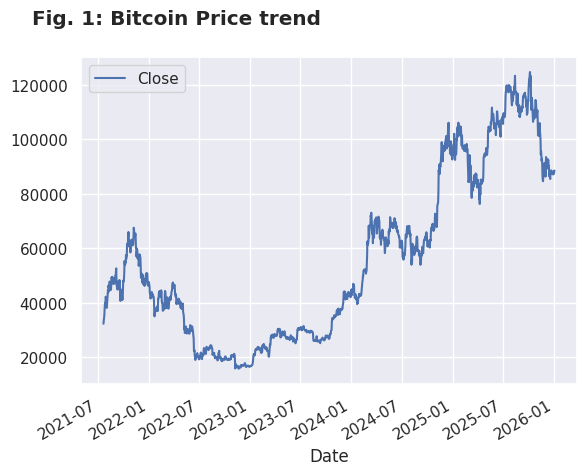

In [17]:
BTC_Data[["Close"]].plot(grid=True)
plt.suptitle(
    "Fig. 1: Bitcoin Price trend", fontweight="bold", horizontalalignment="right"
)
plt.show()

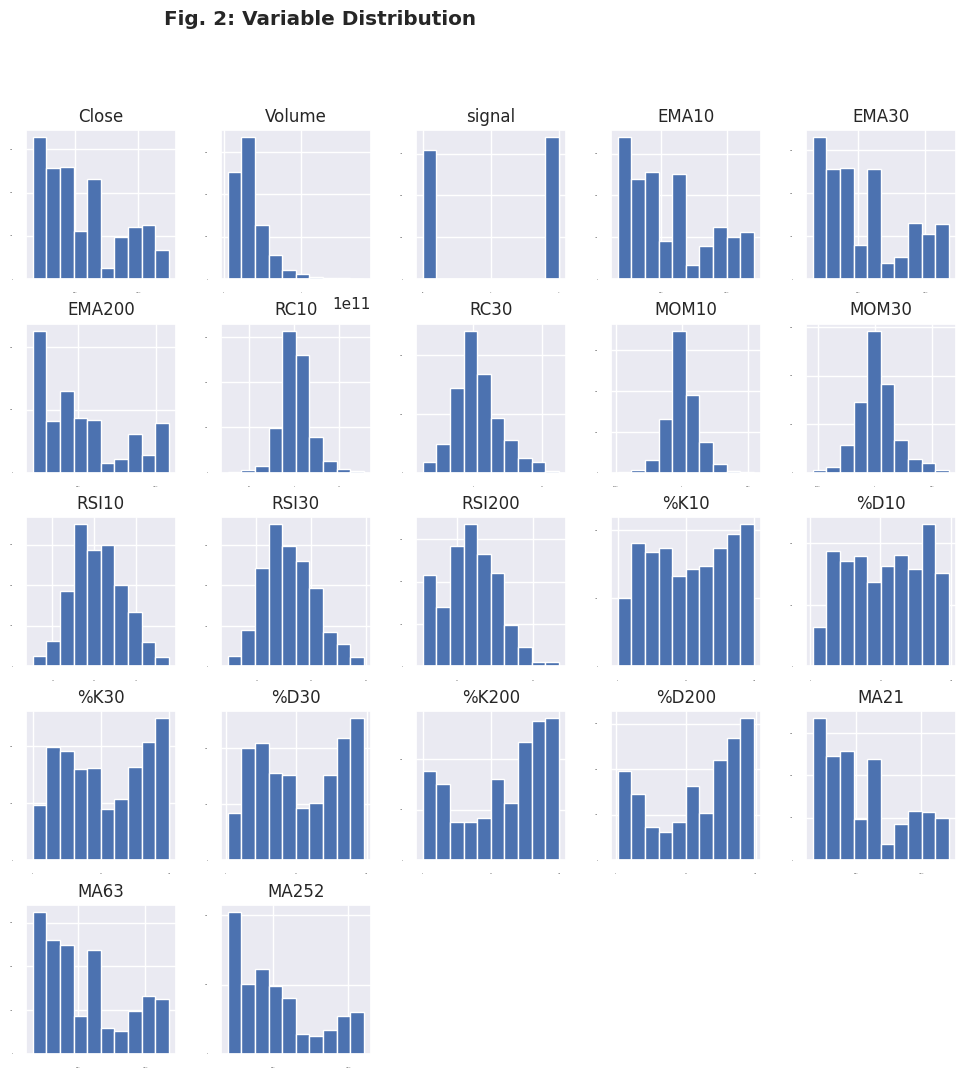

In [18]:
# histograms
BTC_Data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.suptitle(
    "Fig. 2: Variable Distribution", fontweight="bold", horizontalalignment="right"
)
plt.show()

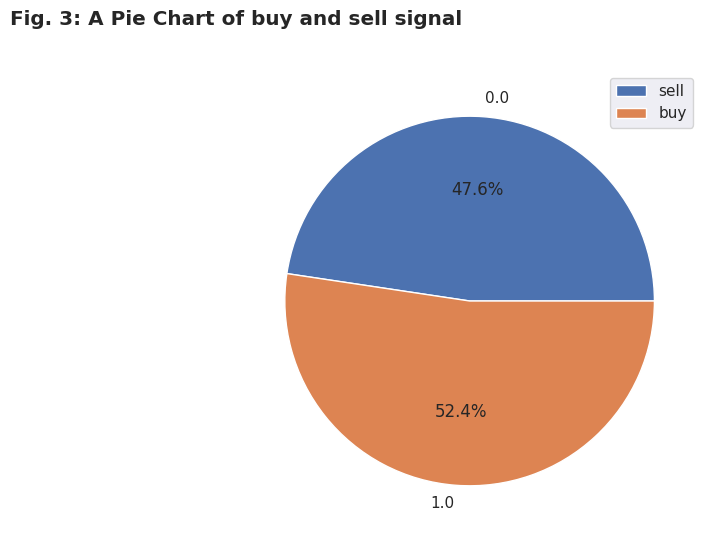

In [19]:
fig = plt.figure()
plot = (
    BTC_Data.groupby("signal")
    .size()
    .plot(kind="pie", figsize=(6, 6), autopct="%1.1f%%", y="Signal")
)
plt.suptitle(
    "Fig. 3: A Pie Chart of buy and sell signal",
    fontweight="bold",
    horizontalalignment="right",
)
plt.legend(["sell", "buy"])
plt.show()

In [20]:
BTC_Data.groupby(["signal"]).size()

signal
0.0    774
1.0    851
dtype: int64

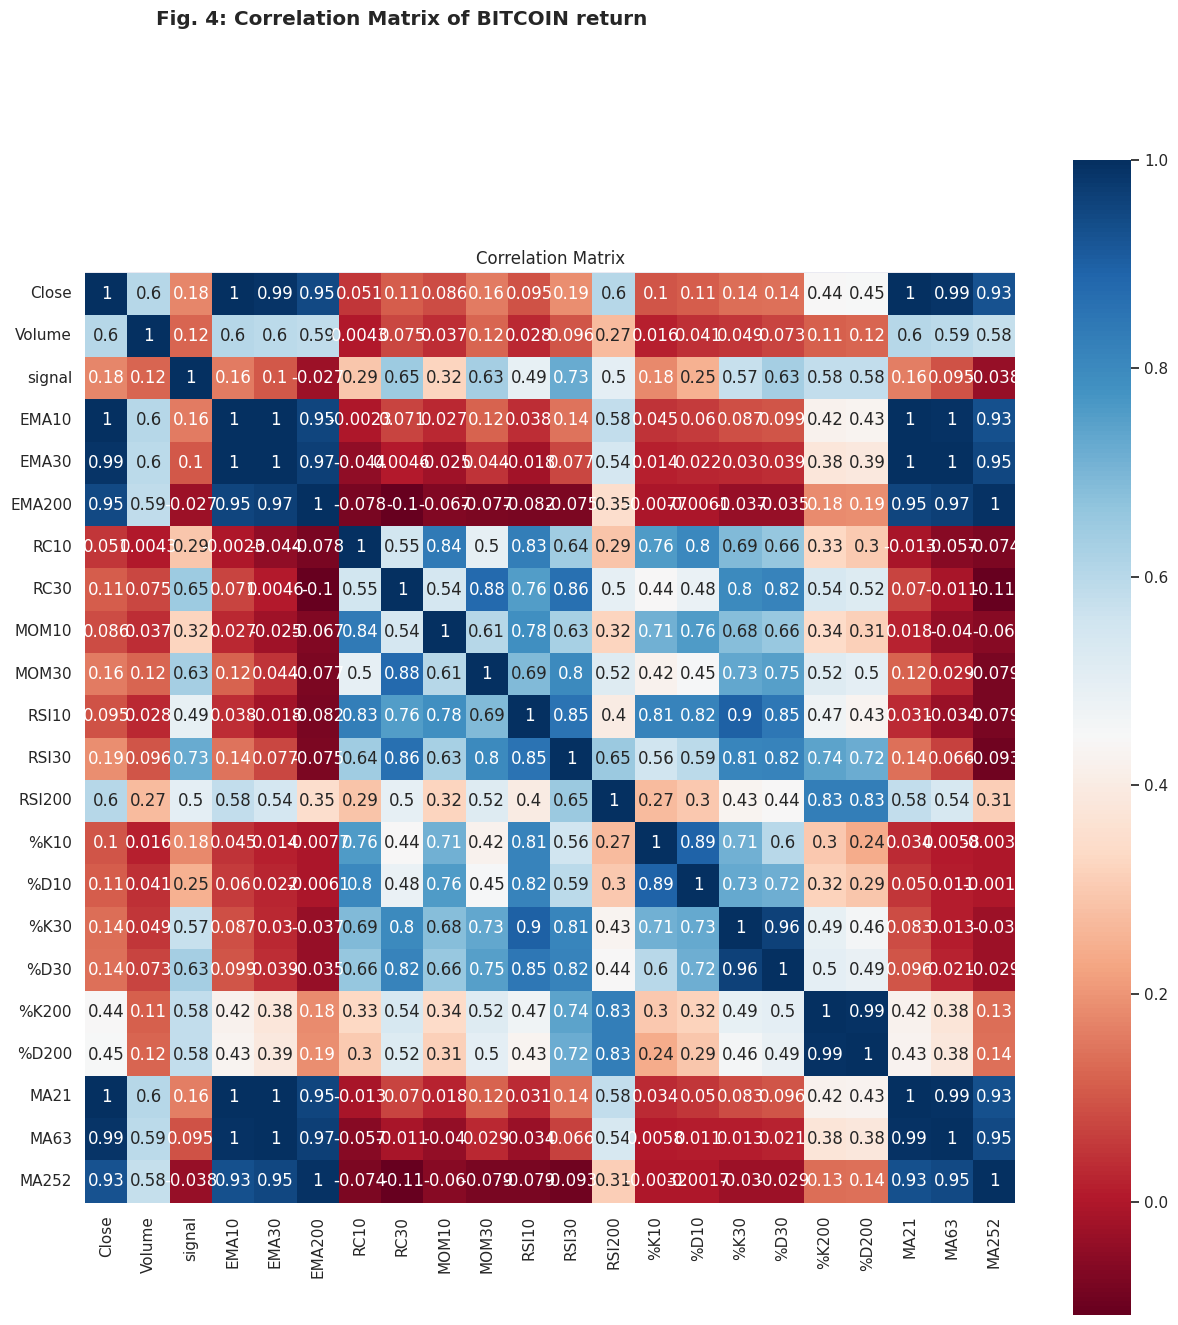

In [21]:
# correlation
BTC_data_returns = BTC_Data.shift(1)
correlation = BTC_data_returns.corr()
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="RdBu")
plt.suptitle(
    "Fig. 4: Correlation Matrix of BITCOIN return",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

In [22]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values("Date").unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start:cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start:holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [23]:
subset_validation = BTC_Data[1301:]

In [24]:
subset_validation.shape

(324, 22)

In [25]:
# split out validation dataset for the end
subset_dataset = BTC_Data[:1300]
y = subset_dataset["signal"]
X = subset_dataset.loc[:, BTC_Data.columns != "signal"]
X.index = pd.to_datetime(X.index)
validation_size = 0.2
seed = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_size, random_state=1
)

In [26]:
subset_dataset.shape

(1300, 22)

In [27]:
subset_validation = BTC_Data[1300:]
y_validation = subset_validation["signal"]
X_validation = subset_validation.loc[:, BTC_Data.columns != "signal"]

In [28]:
X_validation.shape

(325, 21)

In [29]:
# test options for classification
num_folds = 10
seed = 42
scoring = "accuracy"
metrics = {
    "balanced_accuracy": "Accuracy",
    "roc_auc": "AUC",
    "neg_log_loss": "Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision",
    "recall_weighted": "Recall",
}

In [30]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=10, fit_params=None, n_jobs=-1):
    start = time()
    if fit_params is None:
        scores = cross_validate(
            estimator=clf,
            X=X,
            y=y,
            scoring=list(metrics.keys()),
            cv=cv,
            return_train_score=True,
            n_jobs=n_jobs,
            verbose=1,
        )
    else:
        scores = cross_validate(
            estimator=clf,
            X=X,
            y=y,
            scoring=list(metrics.keys()),
            cv=cv,
            return_train_score=True,
            n_jobs=n_jobs,
            verbose=1,
            params=fit_params,   # NEW API
        )
    duration = time() - start
    return scores, duration

In [31]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split("_", 1)) for m in scores.keys()], names=["Dataset", "Metric"]
    )
    data = np.array(list(scores.values())).T
    df = pd.DataFrame(data=data, columns=columns).iloc[:, 2:]
    results = pd.melt(df, value_name="Value")
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [32]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(
        x="Dataset",
        y="Value",
        hue="Dataset",
        col="Metric",
        data=df,
        col_order=m,
        order=["Train", "Test"],
        kind="box",
        col_wrap=3,
        sharey=False,
        height=4,
        aspect=1.2,
    )
    df = df.groupby(["Metric", "Dataset"]).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(
            0.05,
            0.85,
            s,
            fontsize=10,
            transform=ax.transAxes,
            bbox=dict(facecolor="white", edgecolor="grey", boxstyle="round,pad=0.5"),
        )
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    if fname:
        g.savefig(fname, dpi=300);

In [33]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
algo = "dummy_clf"

In [34]:
fname = f"{algo}.joblib"

dummy_cv_result, run_time_algo = run_cv(dummy_clf)
joblib.dump(dummy_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


['dummy_clf.joblib']

In [35]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.492648,0.502146
Accuracy,0.492648,0.502146
F1,0.496914,0.505435
Log Loss,-18.077278,-17.830826
Precision,0.496142,0.505582
Recall,0.498462,0.505299


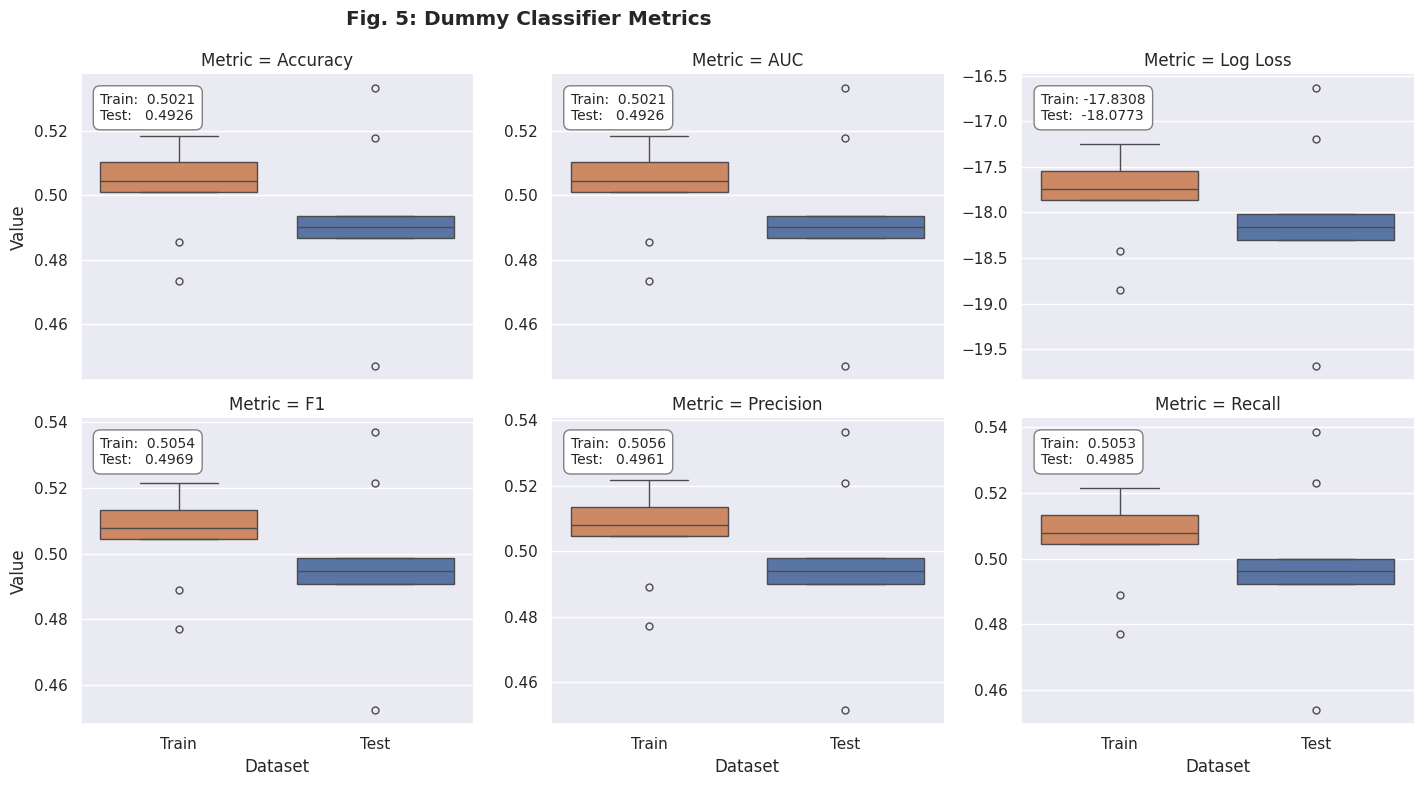

In [36]:
plot_result(dummy_result, model="Dummy Classifier")
plt.suptitle(
    "Fig. 5: Dummy Classifier Metrics", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [37]:
# spot check the algorithms
models = []
models.append(("LR", LogisticRegression(n_jobs=-1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# Neural Network
models.append(("NN", MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs=-1)))

In [38]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/home/dhiraj/miniconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/dhiraj/miniconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dhiraj/miniconda3/envs/mlenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: Future

LR: 0.854808 (0.032876)
LDA: 0.920192 (0.028862)
KNN: 0.550962 (0.043652)
CART: 0.901923 (0.033530)
NB: 0.528846 (0.048077)
NN: 0.488462 (0.057660)
AB: 0.918269 (0.029870)
GBM: 0.932692 (0.025074)
RF: 0.943269 (0.018965)


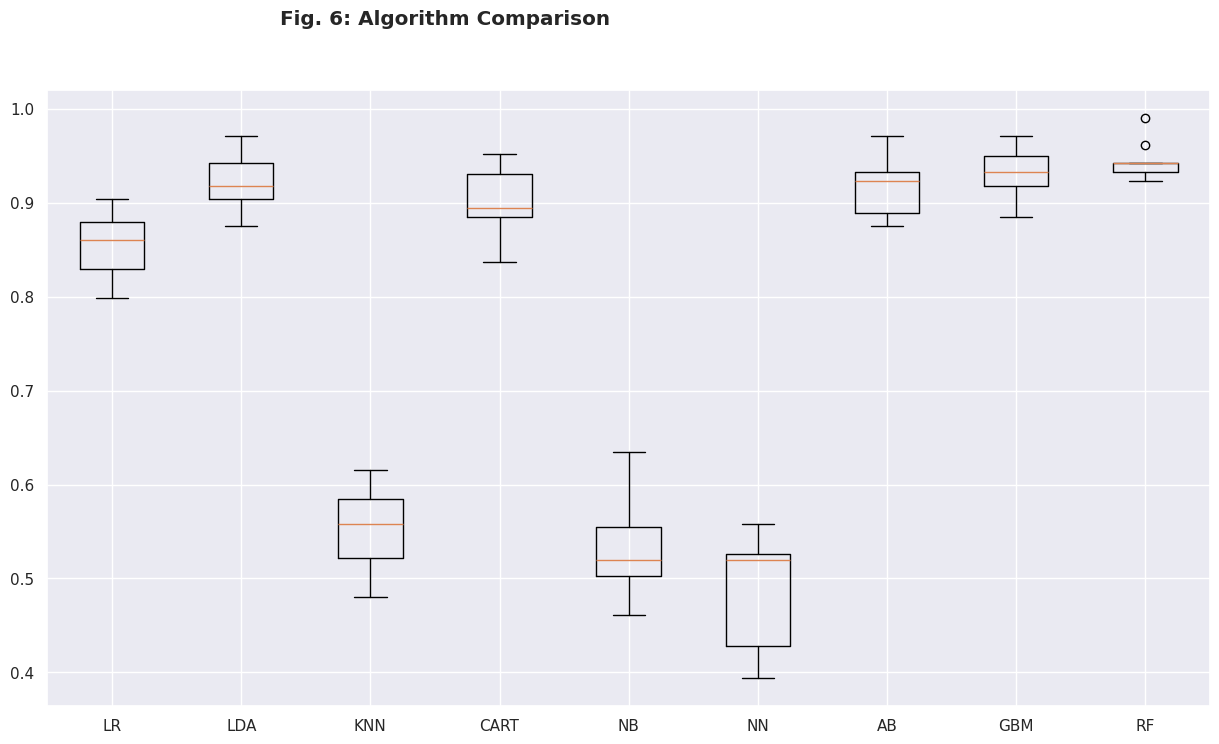

In [39]:
# compare algorithms
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.suptitle(
    "Fig. 6: Algorithm Comparison", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [40]:
# Grid Search: Random Forest Classifier

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth = [5, 10]
criterion = ["gini", "entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.942308 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#7 0.917308 (0.024401) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.920192 (0.021522) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#1 0.942308 (0.016654) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#3 0.938462 (0.021154) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.914423 (0.019916) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.923077 (0.025074) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.934615 (0.022261) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.942308 (0.019706) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [41]:
# prepare model
model = RandomForestClassifier(
    criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
)  # `rbf` is default kernel

In [42]:
algo_forest = "random_forest"

In [43]:
fname = f"{algo_forest}.joblib"

random_forest_cv_result, run_time_algo_forest = run_cv(model)
joblib.dump(random_forest_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished


['random_forest.joblib']

In [44]:
rf_result = stack_results(random_forest_cv_result)
rf_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.895131,1.000000
Accuracy,0.788779,0.999921
F1,0.777515,0.999915
Log Loss,-0.463604,-0.049041
Precision,0.827783,0.999915
Recall,0.790769,0.999915


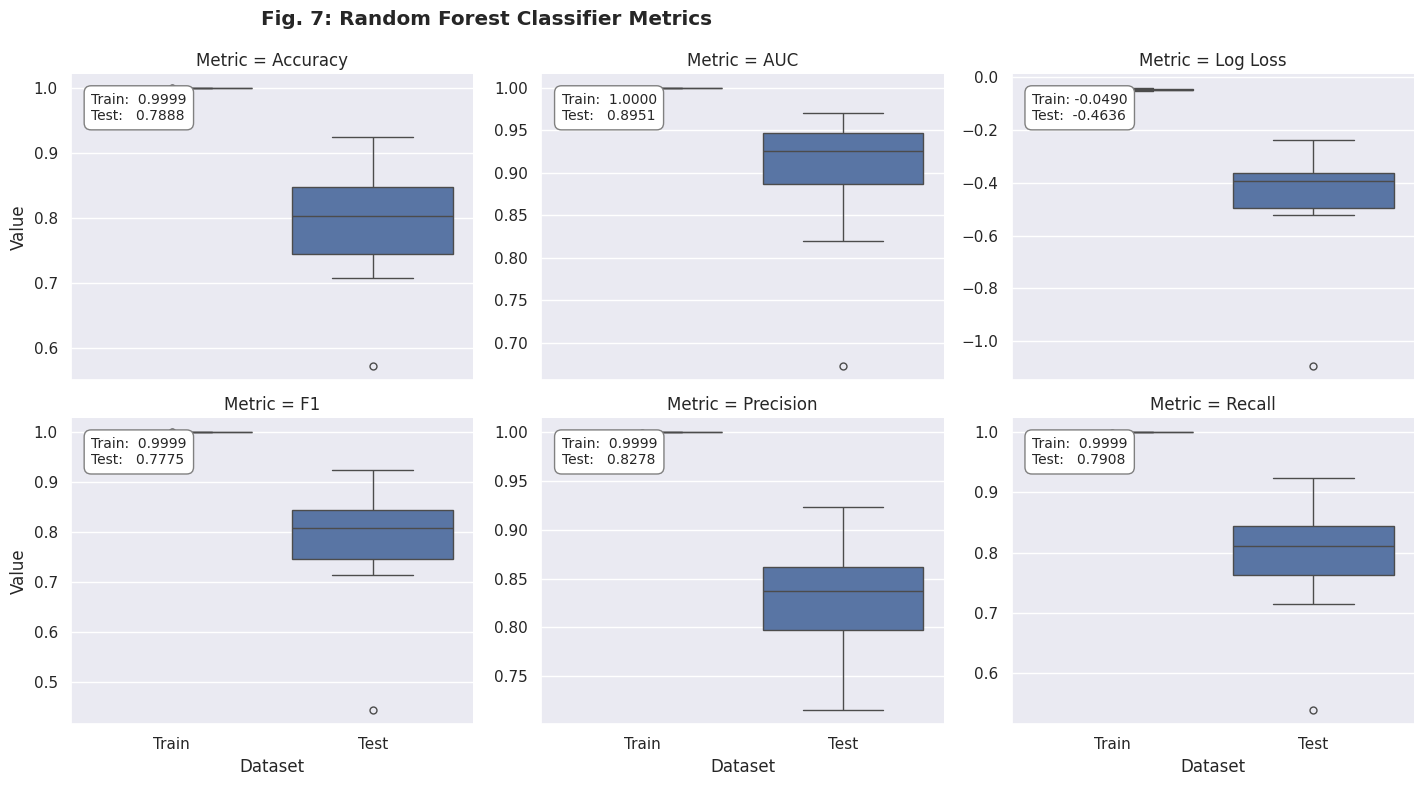

In [45]:
plot_result(rf_result, model="Random Forest Classifier")
plt.suptitle(
    "Fig. 7: Random Forest Classifier Metrics",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

In [46]:
results = {
    "Baseline": dummy_result,
    "Random Forest": rf_result,
}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat(
        [
            df,
            result.groupby(["Metric", "Dataset"])
            .Value.mean()
            .unstack()["Test"]
            .to_frame(model),
        ],
        axis=1,
    )

df.T.sort_values("AUC", ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
Random Forest,0.895131,0.788779,0.777515,-0.463604,0.827783,0.790769
Baseline,0.492648,0.492648,0.496914,-18.077278,0.496142,0.498462


In [47]:
model = RandomForestClassifier(
    criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
)
model.fit(X_train, y_train)
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9346153846153846
[[113   9]
 [  8 130]]
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       122
         1.0       0.94      0.94      0.94       138

    accuracy                           0.93       260
   macro avg       0.93      0.93      0.93       260
weighted avg       0.93      0.93      0.93       260



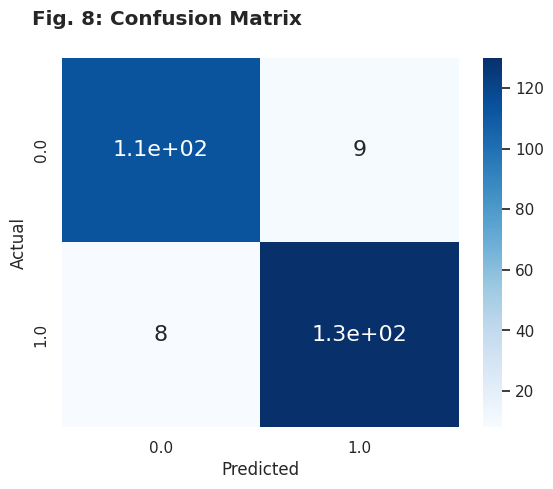

In [48]:
df_cm = pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=np.unique(y_test),
    index=np.unique(y_test),
)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font sizes
plt.suptitle("Fig. 8: Confusion Matrix", fontweight="bold", horizontalalignment="right")
plt.show()

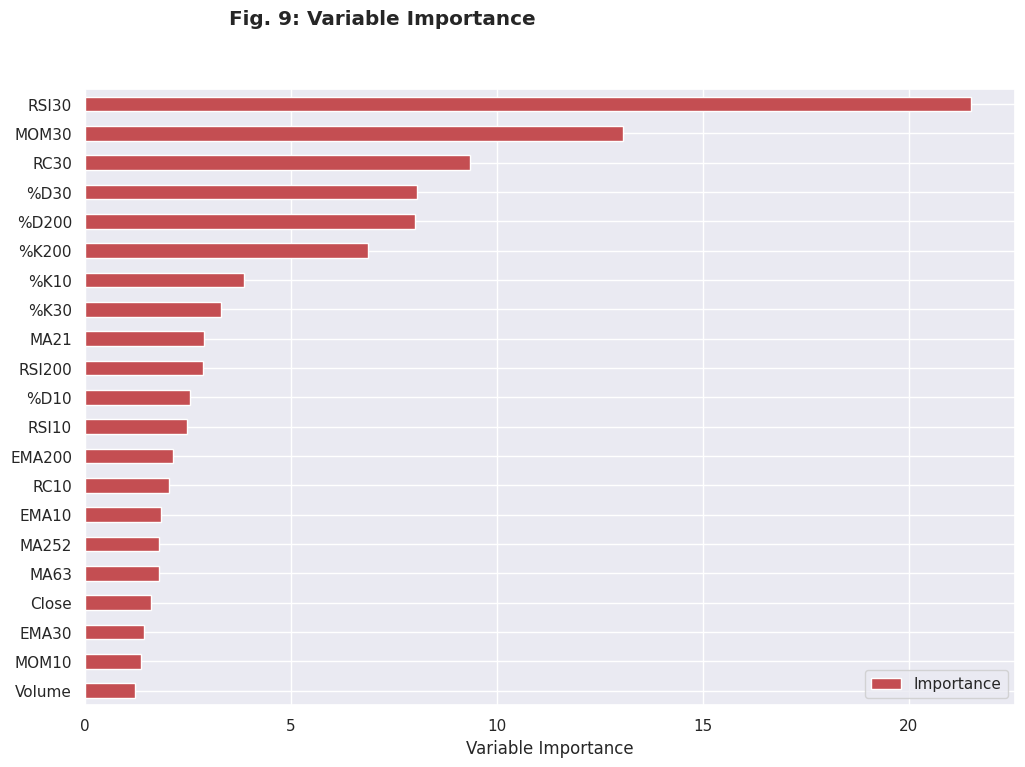

In [49]:
Importance = pd.DataFrame(
    {"Importance": model.feature_importances_ * 100}, index=X.columns
)
Importance.sort_values("Importance", axis=0, ascending=True).plot(
    kind="barh", color="r", figsize=(12, 8)
)
plt.xlabel("Variable Importance")
plt.suptitle(
    "Fig. 9: Variable Importance", fontweight="bold", horizontalalignment="right"
)
plt.show()

In [50]:
def stratified_kfold_score(clf, X_train, y_train, n_fold):
    X, y = X_train.values, y_train.values
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds, y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

In [51]:
def bo_params_rf(max_samples, n_estimators, max_features):
    params = {
        "max_samples": max_samples,
        "max_features": max_features,
        "n_estimators": int(n_estimators),
    }
    clf = RandomForestClassifier(
        max_samples=params["max_samples"],
        max_features=params["max_features"],
        n_estimators=params["n_estimators"],
    )
    score = stratified_kfold_score(clf, X_train, y_train, 5)
    return score

In [52]:
rf_bo = BayesianOptimization(
    bo_params_rf,
    {"max_samples": (0.2, 1), "max_features": (0.5, 1), "n_estimators": (50, 200)},
)

In [53]:
results = rf_bo.maximize(n_iter=200, init_points=20)

|   iter    |  target   | max_sa... | max_fe... | n_esti... |
-------------------------------------------------------------
| 1         | 0.9317307 | 0.7785415 | 0.6454080 | 73.322535 |
| 2         | 0.9317307 | 0.9587457 | 0.6718790 | 56.341028 |
| 3         | 0.9269230 | 0.5405855 | 0.9097501 | 178.44882 |
| 4         | 0.9346153 | 0.9386089 | 0.5768677 | 60.924071 |
| 5         | 0.9317307 | 0.7415830 | 0.5099875 | 118.11800 |
| 6         | 0.9278846 | 0.5449745 | 0.8961692 | 185.98903 |
| 7         | 0.9278846 | 0.5201281 | 0.6637416 | 192.62030 |
| 8         | 0.9125    | 0.2304333 | 0.9244146 | 190.73635 |
| 9         | 0.9144230 | 0.2038209 | 0.8310684 | 68.778859 |
| 10        | 0.9125000 | 0.2403978 | 0.6950602 | 79.378901 |
| 11        | 0.9269230 | 0.7312901 | 0.8981707 | 143.09346 |
| 12        | 0.9182692 | 0.3255294 | 0.5533571 | 53.550004 |
| 13        | 0.9230769 | 0.3840094 | 0.8759887 | 145.28150 |
| 14        | 0.9221153 | 0.3697331 | 0.5670947 | 195.38360 |
| 15    

In [54]:
params = rf_bo.max["params"]
params["n_estimators"] = int(params["n_estimators"])
print(params)

{'max_samples': np.float64(0.9914366478156766), 'max_features': np.float64(0.5537471358725485), 'n_estimators': 60}


In [55]:
rf_v1 = RandomForestClassifier(
    max_samples=params["max_samples"],
    max_features=params["max_features"],
    n_estimators=params["n_estimators"],
)

In [56]:
rf_v1.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",60
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",np.float64(0.5537471358725485)
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable

In [57]:
preds = rf_v1.predict(X_test)

In [58]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       119
         1.0       0.94      0.92      0.93       141

    accuracy                           0.93       260
   macro avg       0.93      0.93      0.93       260
weighted avg       0.93      0.93      0.93       260



In [59]:
print("Precision:{}".format(precision_score(preds, y_test)))
print("Recall:{}".format(recall_score(preds, y_test)))
print("F1 Score:{}".format((f1_score(preds, y_test))))

Precision:0.9420289855072463
Recall:0.9219858156028369
F1 Score:0.931899641577061


In [60]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
scores = []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    rf_v1.fit(X.iloc[train], y.iloc[train])
    preds = rf_v1.predict(X_train.iloc[test])
    accuracy = accuracy_score(preds, y_train.iloc[test])
    scores.append(accuracy)

df_val = pd.DataFrame(scores, columns=["Accuracy Test"])
print(
    "KFold validation mean accuracy on test set : {}".format(
        df_val["Accuracy Test"].mean()
    )
)

KFold validation mean accuracy on test set : 0.9625


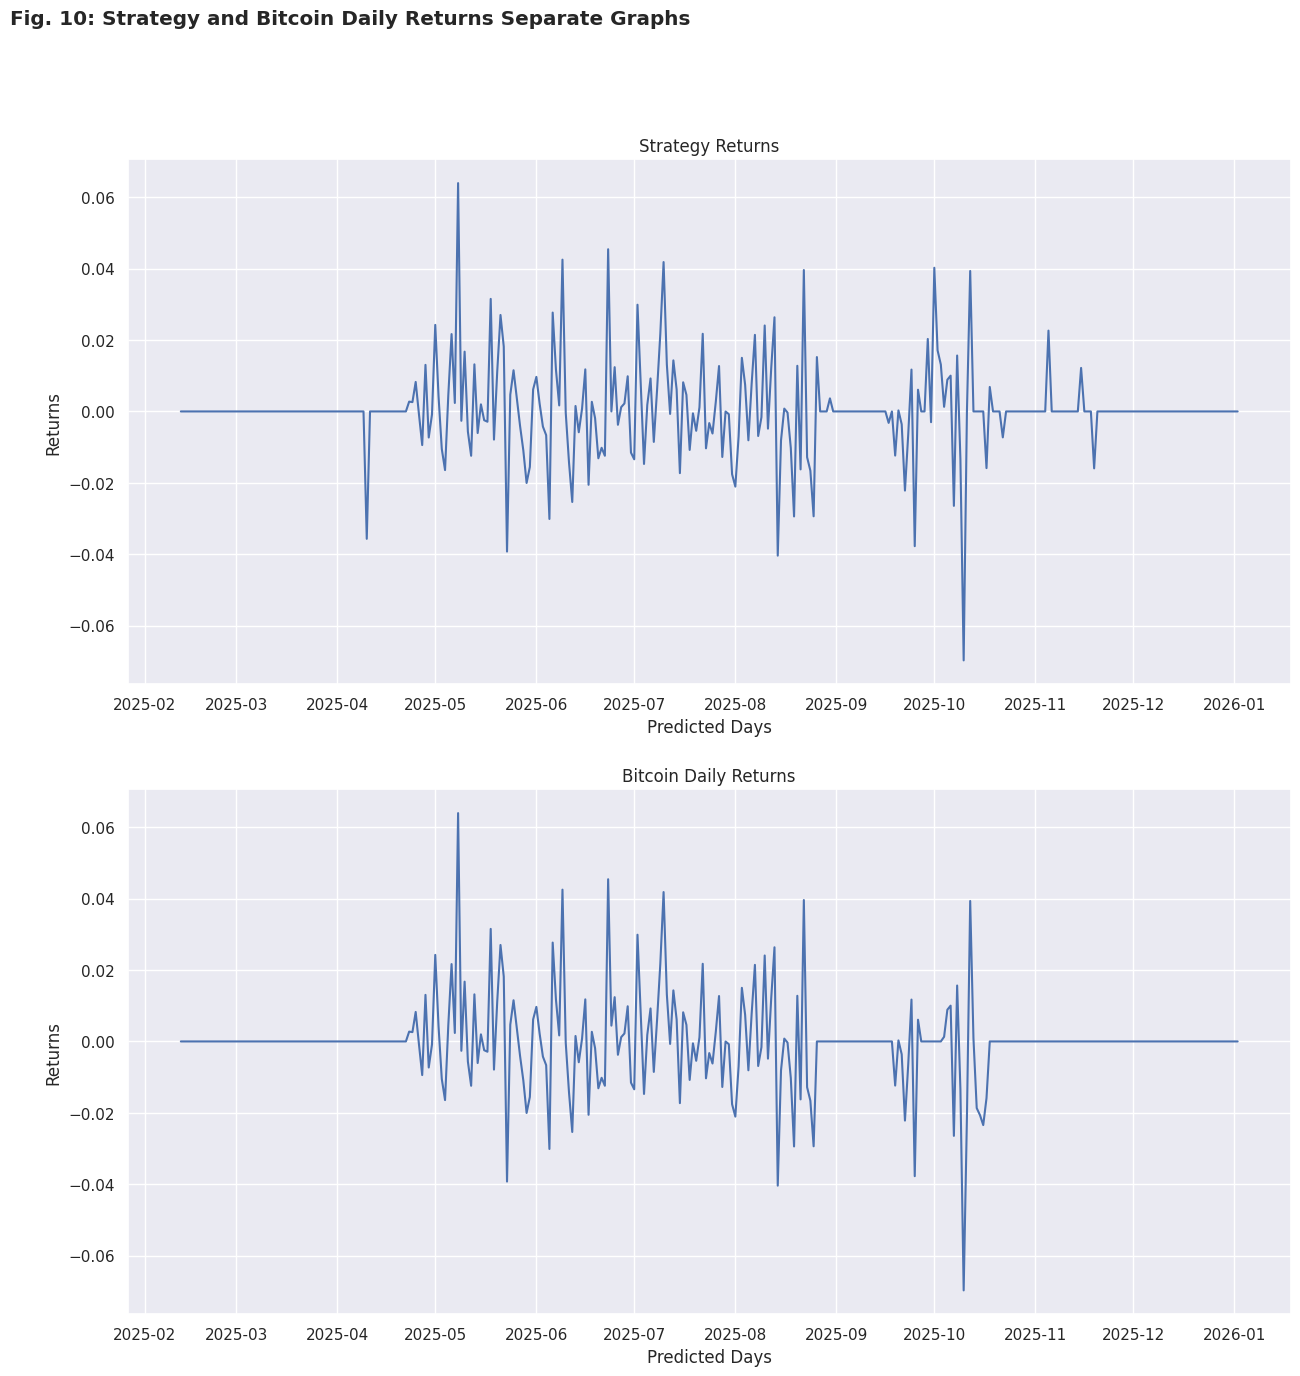

In [61]:
# Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
# of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
validation_prediction = rf_v1.predict(X_validation)
backtestdata["signal_pred"] = validation_prediction
backtestdata["signal_actual"] = y_validation
backtestdata["Market Returns"] = X_validation["Close"].pct_change()
backtestdata["Actual Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_actual"
].shift(1)
backtestdata["Strategy Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_pred"
].shift(1)
# backtestdata=backtestdata.reset_index()
backtestdata.head()

fig, axs = plt.subplots(2, figsize=(15, 15))
fig.suptitle("Vertically stacked subplots")
axs[0].plot(backtestdata["Strategy Returns"])
axs[0].set_title("Strategy Returns")
axs[1].plot(backtestdata["Actual Returns"])
axs[1].set_title("Bitcoin Daily Returns")

for ax in axs.flat:
    ax.set(xlabel="Predicted Days", ylabel="Returns")

# `backtestdata`[['Strategy Returns','Actual Returns']].plot()
# `plt.title`('Cumulative Strategy Returns vs Cumulative Actual Returns')
plt.suptitle(
    "Fig. 10: Strategy and Bitcoin Daily Returns Separate Graphs",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

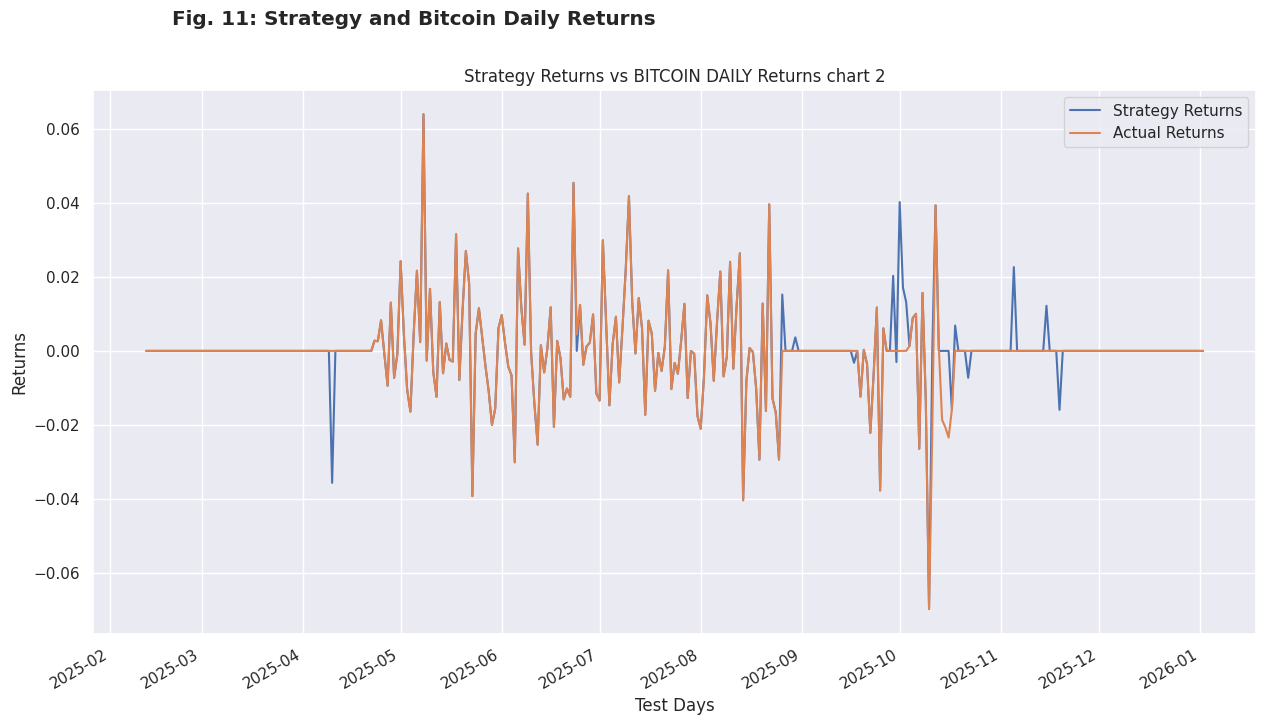

In [62]:
backtestdata[["Strategy Returns", "Actual Returns"]].plot(figsize=(15, 8))
plt.title("Strategy Returns vs BITCOIN DAILY Returns chart 2")
plt.suptitle(
    "Fig. 11: Strategy and Bitcoin Daily Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.xlabel("Test Days")
plt.ylabel("Returns")
plt.show()

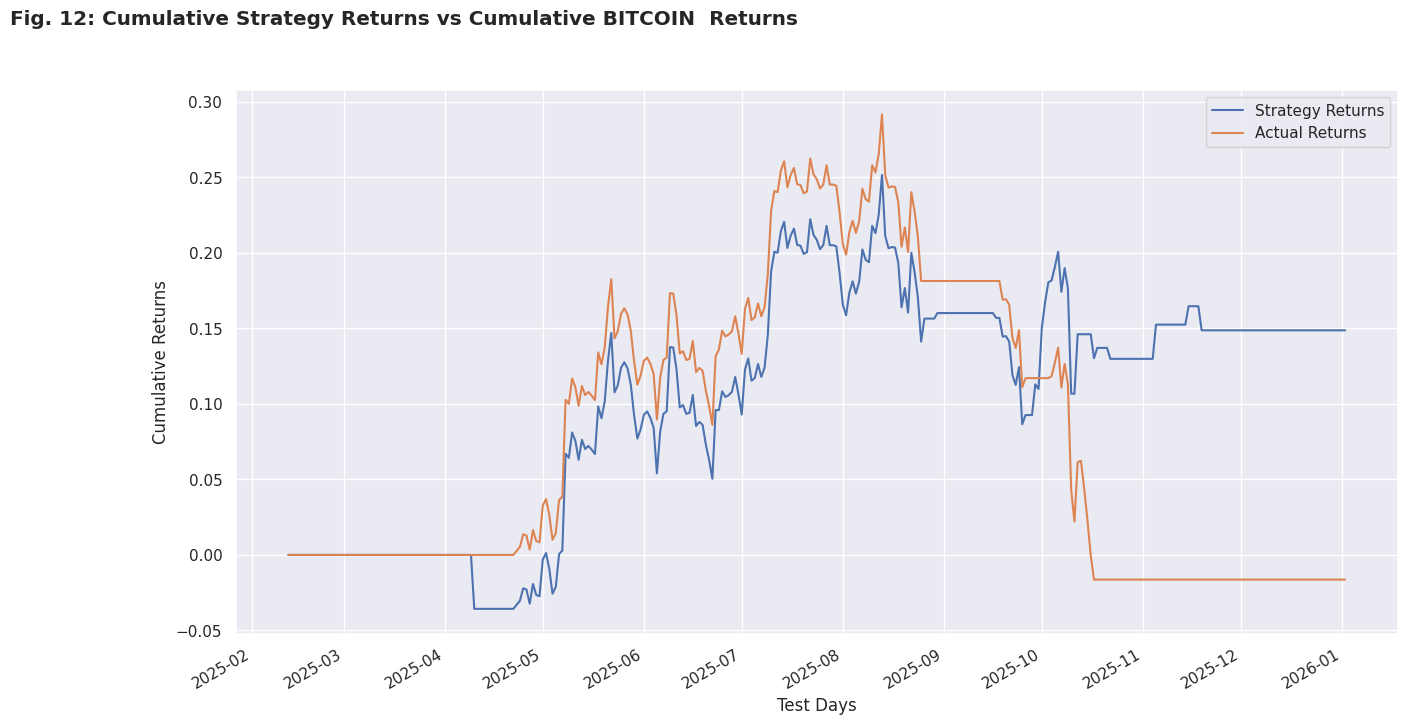

In [63]:
backtestdata[["Strategy Returns", "Actual Returns"]].cumsum().plot(figsize=(15, 8))
plt.xlabel("Test Days")
plt.ylabel("Cumulative Returns")
plt.suptitle(
    "Fig. 12: Cumulative Strategy Returns vs Cumulative BITCOIN  Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()